# Compare tangential shear profiles from the extragalactic and object catalogs for DC2 Run 2.1i

This notebook can be run at NERSC or CC-IN2P3 where the DESC DC2 products are stored. You need to be a DESC member to be able to access those. The DC2 catalog-related imports below (`FoFCatalogMatching`, `GCR` and `GCRCatalogs`) are readily available from the `desc` conda environement at NERC or CC-IN2P3. If working outside such environment, these packagea first need to be installed. 

This was put together using:
- the DC2 analysis tutorials (in particular [matching_fof.ipynb](https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/matching_fof.ipynb) and [object_gcr_2_lensing_cuts.ipynb](https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/object_gcr_2_lensing_cuts.ipynb))
- the CLMM usage examples


In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.table import Table

# DC2 catalog-related imports
import FoFCatalogMatching
import GCRCatalogs
from GCR import GCRQuery

#CLMM imports
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm

/sps/lsst/data/boutigny/desc/mydesc_3/lib/python3.7/site-packages/GCRCatalogs/register.py:138: UserWarning: Site determined from env variable DESC_GCR_SITE = in2p3, which differs from node name cf41cde7a227
  self._DESC_SITE_ENV, site_from_env, site_from_socket


### 1. Load the catalogs
- DC2 object catalog
- DC2 extragalactic catalog (cosmoDC2)

In [2]:
%%time
object_cat = GCRCatalogs.load_catalog('dc2_object_run2.1i_dr1')

CPU times: user 464 ms, sys: 112 ms, total: 575 ms
Wall time: 2.2 s


In [3]:
%%time
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small',)

CPU times: user 571 ms, sys: 60.7 ms, total: 632 ms
Wall time: 3.67 s


### 2. Identify one halo in the extragalactic catalog
Choosing the most massive one below z = 0.4. The `halo_mass` field of the cosmoDC2 catalog gives the mass in units of M$_{\odot}$.

In [4]:
%%time
# get list of massive halos in a given redshift and mass range
mmin = 5.e14 #Msun
zmax = 0.4

massive_halos = extragalactic_cat.get_quantities(['halo_mass','hostHaloMass','redshift','ra', 'dec', 'halo_id'],\
                                                 filters=[f'halo_mass > {mmin}','is_central==True',
                                                          f'redshift<{zmax}'])

N_cl = len(massive_halos['halo_mass'])
print(f'There are {N_cl} clusters in that mass and redshift ranges')

There are 12 clusters in that mass and redshift ranges
CPU times: user 2.01 s, sys: 15.1 s, total: 17.1 s
Wall time: 59.8 s


In [5]:
%%time
# Selecting the most massive one
select = massive_halos['halo_mass'] == np.max(massive_halos['halo_mass'])
ra_cl = massive_halos['ra'][select][0]
dec_cl = massive_halos['dec'][select][0]
z_cl = massive_halos['redshift'][select][0]
mass_cl =massive_halos['halo_mass'][select][0]
id_cl = massive_halos['halo_id'][select][0]

print (f'The most massive cluster is halo {id_cl}, in ra = {ra_cl:.2f} deg, dec = {dec_cl:.2f} deg, z = {z_cl:.2f}, with mass = {mass_cl:.2e} Msun')

The most massive cluster is halo 135700142421, in ra = 63.29 deg, dec = -39.65 deg, z = 0.19, with mass = 1.24e+15 Msun
CPU times: user 839 µs, sys: 22 µs, total: 861 µs
Wall time: 709 µs


### 3. Selection of background galaxies around the cluster
- Define cuts on the cosmoDC2 and object catalogs. 
    - Box of 0.7 deg around the cluster center
    - Galaxies with z > z_cluster + 0.1
    - Galaxies with mag_i < 24.5
- We also add some WL quality cuts for the object catalog.
- The two catalogs will then be matched to end up with the same selection of galaxies.

#### 3.1 Cut definition

NB: the object catalog quality cuts follow that given in the [object_gcr_2_lensing_cuts.ipynb](https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/object_gcr_2_lensing_cuts.ipynb) notebook.

In [6]:
%%time
# Coordinate filter to be applied applied to both extragalactic and object catalog
ra_min, ra_max = ra_cl-0.35, ra_cl+0.35
dec_min, dec_max = dec_cl-0.35, dec_cl+0.35

coord_filters = [
    f'ra >= {ra_min}',
    f'ra < {ra_max}',
    f'dec >= {dec_min}',
    f'dec < {dec_max}',
]

# Redshift cut to be applied to the extragalactic catalog. The object catalog does not have redshift information.
z_min = z_cl + 0.1
redshift_filters = [
    (np.isfinite, 'redshift'),
    f'redshift > {z_min}',
]

# Magnitude cut to be applied to both catalogs
mag_filters = [
    (np.isfinite, 'mag_i'),
    'mag_i < 24.5',
]

# Following DC2 tutorials, basics cuts to be applied to the object catalog
object_basic_cuts = [
    GCRQuery('extendedness > 0'),     # Extended objects
    GCRQuery((np.isfinite, 'mag_i')), # Select objects that have i-band magnitudes
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
    GCRQuery('xy_flag == 0'),                                      # Flag for centroid measurement (0 if OK)
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_flag == 0'),            # Flag returned by shape measurement code (0 if OK)
    GCRQuery((np.isfinite, 'ext_shapeHSM_HsmShapeRegauss_sigma')), # Shape measurement uncertainty should not be NaN
]

# Adding the total ellipticity quantity to the object catalog
object_cat.add_quantity_modifier('shape_hsm_regauss_etot', 
                                 (np.hypot, 'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2'), 
                                 overwrite=True)

# Following DC2 tutorials, additional WL quality cuts to be applied to the object catalog
object_properties_cuts = [
    GCRQuery('snr_i_cModel > 10'),                              # SNR > 10
    GCRQuery('mag_i_cModel < 24.5'),                            # cModel imag brighter than 24.5
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_resolution >= 0.3'), # Sufficiently resolved galaxies compared to PSF
    GCRQuery('shape_hsm_regauss_etot < 2'),                     # Total distortion in reasonable range
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),      # Shape measurement errors reasonable
    GCRQuery('blendedness < 10**(-0.375)')                      # Avoid spurious detections and those contaminated by blends
]

CPU times: user 133 µs, sys: 12 µs, total: 145 µs
Wall time: 153 µs


#### 3.2 Load quantities from both catalogs, given the cuts defined above

In [7]:
%%time
extragal_data = extragalactic_cat.get_quantities(['ra', 'dec', 'shear_1', 'shear_2', 
                                                  'ellipticity_1_true', 'ellipticity_2_true',
                                                  'redshift', 'convergence', 'galaxy_id'], 
                                                 filters=(coord_filters + mag_filters + redshift_filters))

CPU times: user 1min 10s, sys: 46.1 s, total: 1min 56s
Wall time: 3min 4s


For the object catalog below, the field under scrutiny falls in tract 3448. A DM-stack installation is required to identify a tract given a set of coordinates (this was done separately from this notebook). In any case, specifying that tract using `native_filters` speeds up the process but is not required.


In [8]:
%%time
object_data = object_cat.get_quantities(['ra', 'dec',
                                         'ext_shapeHSM_HsmShapeRegauss_e1','ext_shapeHSM_HsmShapeRegauss_e2', 
                                         'id'],
                                        native_filters=['tract == 3448'],
                                        filters=(coord_filters + object_basic_cuts + object_properties_cuts))

CPU times: user 558 ms, sys: 445 ms, total: 1 s
Wall time: 792 ms


/sps/lsst/data/boutigny/desc/mydesc_3/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:44: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/sps/lsst/data/boutigny/desc/mydesc_3/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:44: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


### 4. Match the 2 catalogs

Using the `FoFCatalogMatching` method; this was examplified in the [DC2 analysis tutorial](https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/matching_fof.ipynb) and adapted to our purpose here. As mentioned in the tutorial, *`FoFCatalogMatching.match` takes a dictionary of catalogs to match and a friends-of-friends linking length. Because the "catalog" is not an astropy table or pandas dataframe, `len(truth_coord)` won't give the actual length of the table so we need to specify `catalog_len_getter` so that the code knows how to get the length of the catalog.*

NB: `linking_lengths` is in arcsec. Here, we ask `FoFCatalogMatching` to use a linking length of 1 arcsec.


#### 4.1 Perform the matching

In [9]:
%%time
results = FoFCatalogMatching.match(
    catalog_dict={'extragal': extragal_data, 'object': object_data},
    linking_lengths=1.,
    catalog_len_getter=lambda x: len(x['ra']),
)

# identify which rows are from the extragalactic catalog and which are from the object
extragal_mask = results['catalog_key'] == 'extragal'
object_mask = ~extragal_mask

# np.bincount will give up the number of id occurrences (like histogram but with integer input)
n_groups = results['group_id'].max() + 1
n_extragal = np.bincount(results['group_id'][extragal_mask], minlength=n_groups)
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)

CPU times: user 3.83 s, sys: 15.8 ms, total: 3.84 s
Wall time: 3.85 s


#### 4.2 Identify one-to-one extragal/object matches

In [10]:
%%time
one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_extragal == 1) & (n_object == 1)))

# Row indices in the *original* extragal/object catalogs for those 1-to-1 groups
extragal_idx = results['row_index'][one_to_one_group_mask & extragal_mask]
object_idx = results['row_index'][one_to_one_group_mask & object_mask]
print(f'Number of 1-to-1 matched objects: {len(extragal_idx)}, {len(object_idx)}')

Number of 1-to-1 matched objects: 14999, 14999
CPU times: user 12.4 ms, sys: 0 ns, total: 12.4 ms
Wall time: 10.5 ms


### 5. Computes the reduced tangential shear profiles from both datasets, using CLMM

#### 5.1 First, dealing with the cosmoDC2 data.
To measure a reduced tangential shear profile, the shape measurements must be made according to the $\epsilon$ or reduced shear definition $g$. So first , we convert cosmoDC2 `shear1` and `shear2` quantities to reduced shear using the `convergence`. These become the `e1` and `e2` fields of the CLMM cluster galaxy catalog.

In [11]:
%%time
e1, e2 = clmm.utils.convert_shapes_to_epsilon(extragal_data['shear_1'][extragal_idx],extragal_data['shear_2'][extragal_idx],
                                              shape_definition='shear',kappa=extragal_data['convergence'][extragal_idx])

# Create the background galaxy catalog as a CLMM GCData (= astropy table)
dat = clmm.GCData([extragal_data['ra'][extragal_idx],extragal_data['dec'][extragal_idx],e1,
      e2,extragal_data['redshift'][extragal_idx],extragal_data['galaxy_id'][extragal_idx]], 
      names=('ra','dec', 'e1', 'e2', 'z','id'))

# Instantiate a CLMM cluster object and save it for later use.
cl_from_cosmoDC2 = clmm.GalaxyCluster(str(id_cl), ra_cl, dec_cl, z_cl, dat)   
cl_from_cosmoDC2.save('cosmoDC2_GC.pkl')

CPU times: user 9.39 ms, sys: 0 ns, total: 9.39 ms
Wall time: 17.9 ms


#### 5.2 Second, doing the same for the DC2 object catalog
In the object catalog, shapes are measured by `shapeHSM` which return ellipticities according to the $\chi$ definition. Need to convert to the $\epsilon$ definition, once again using the conversion helper function from CLMM. 

In [12]:
%%time
e1, e2 = clmm.utils.convert_shapes_to_epsilon(object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx],
                                              object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx],
                                              shape_definition='chi')

# The conversion may create NaN, so avoid these by creating a mask
mask = np.isfinite(e1)

CPU times: user 4.09 ms, sys: 0 ns, total: 4.09 ms
Wall time: 2.94 ms


/sps/lsst/data/boutigny/desc/mydesc_3/lib/python3.7/site-packages/clmm/utils.py:229: RuntimeWarning: invalid value encountered in sqrt
  chi_to_eps_conversion = 1./(1.+(1-(shape_1**2 + shape_2**2))**0.5)


The object catalog has no redshift information so we'll use the redshift of the matched galaxies in cosmoDC2 to create the GalaxyCluster object.

In [13]:
%%time
# Create the background galaxy catalog as a CLMM GCData (= astropy table)
dat = clmm.GCData([object_data['ra'][object_idx][mask],object_data['dec'][object_idx][mask],
             e1[mask],
             e2[mask],
             extragal_data['redshift'][extragal_idx][mask],
             object_data['id'][object_idx][mask]], 
            names=('ra','dec', 'e1', 'e2', 'z','id'), masked=True)


# Create the background galaxy catalog as astropy table and save it for later use
cl_from_objectDC2 = clmm.GalaxyCluster(str(id_cl), ra_cl, dec_cl, z_cl, dat)  
cl_from_objectDC2.save('objectDC2_GC.pkl')

CPU times: user 4.83 ms, sys: 6.7 ms, total: 11.5 ms
Wall time: 19.2 ms


#### 5.3 Build the reduced tangential shear profile from both datasets

In [14]:
%%time
cl_from_objectDC2 = clmm.GalaxyCluster.load('objectDC2_GC.pkl')
cl_from_cosmoDC2 = clmm.GalaxyCluster.load('cosmoDC2_GC.pkl')

CPU times: user 8.82 ms, sys: 3.6 ms, total: 12.4 ms
Wall time: 12.5 ms


In [15]:
%%time
cosmo = extragalactic_cat.cosmology
bin_edges = clmm.polaraveraging.make_bins(0.15, 4, 10, method='evenlog10width')

cl_from_cosmoDC2.compute_tangential_and_cross_components(geometry="flat")
profile_from_cosmoDC2 = cl_from_cosmoDC2.make_binned_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)

cl_from_objectDC2.compute_tangential_and_cross_components(geometry="flat")
profile_from_objectDC2 = cl_from_objectDC2.make_binned_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)

CPU times: user 661 ms, sys: 4.13 ms, total: 666 ms
Wall time: 664 ms


#### 5.4 Taking into account intrinsic ellipticities from cosmoDC2

So far, we've used the `shear1` and `shear2` fields of cosmoDC2, i.e., we neglected the intrinsic ellipticities of the galaxies. To account for shape noise from intrinsic ellipticities, we can use the shears and unlensed ellipticities available in the cosmoDC2 catalog to build lensed ellipticities (this is done using the `compute_lensed_ellipticity` function available in CLMM - see the documentation for details). The latter can then be used to bluid a CLMM cluster object. The resulting tangential shear profile will then include shape noise.

In [16]:
%%time
es1 = extragal_data['ellipticity_1_true']
es2 = extragal_data['ellipticity_2_true']
gamma1 = extragal_data['shear_1']
gamma2 = extragal_data['shear_2']
kappa = extragal_data['convergence']

extragal_data['ellipticity_1'] = clmm.utils.compute_lensed_ellipticity(es1, es2, gamma1, gamma2, kappa)[0]
extragal_data['ellipticity_2'] = clmm.utils.compute_lensed_ellipticity(es1, es2, gamma1, gamma2, kappa)[1]

CPU times: user 5.99 ms, sys: 0 ns, total: 5.99 ms
Wall time: 5.03 ms


Make a new CLMM cluster object

In [17]:
dat = clmm.GCData([extragal_data['ra'][extragal_idx],extragal_data['dec'][extragal_idx],
             extragal_data['ellipticity_1'][extragal_idx],
             extragal_data['ellipticity_2'][extragal_idx],
             extragal_data['redshift'][extragal_idx],
             extragal_data['galaxy_id'][extragal_idx]],
            names=('ra','dec', 'e1', 'e2', 'z','id'))

cl_from_cosmoDC2_with_e1e2 = clmm.GalaxyCluster(str(id_cl), ra_cl, dec_cl, z_cl, dat) 

Compute the reduced shear profile

In [18]:
cl_from_cosmoDC2_with_e1e2.compute_tangential_and_cross_components(geometry="flat")
profile_from_cosmoDC2_with_e1e2 = cl_from_cosmoDC2_with_e1e2.make_binned_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)

### 6. Visualize the results for the three profiles, obtained from the same galaxies in the two catalogs
- from cosmoDC2, neglecting shape noise (blue points)
- from cosmoDC2, including shape noise (orange)
- for the DC2 object catalog (green, where the galaxies redshifts taken from cosmoDC2)

(0.002, 0.3)

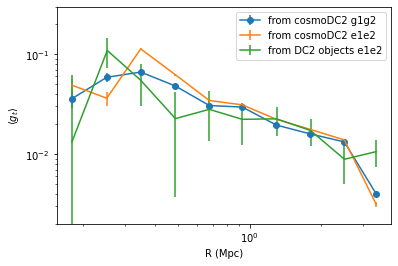

In [19]:
plt.errorbar(profile_from_cosmoDC2['radius'],profile_from_cosmoDC2['gt'],profile_from_cosmoDC2['gt_err'], 
             marker='o',label='from cosmoDC2 g1g2')
plt.errorbar(profile_from_cosmoDC2_with_e1e2['radius'],profile_from_cosmoDC2_with_e1e2['gt'],
             profile_from_cosmoDC2['gt_err'],label='from cosmoDC2 e1e2')
plt.errorbar(profile_from_objectDC2['radius'],profile_from_objectDC2['gt'],profile_from_objectDC2['gt_err'], 
             label='from DC2 objects e1e2')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R (Mpc)')
plt.ylabel(r'$\langle g_t \rangle$')
plt.ylim([2.e-3,0.3])

From cosmoDC2 (orange and blue profiles above), we see the impact of shape noise at low radii (orange/blue =w/wo intrinsic ellipticities), where the number of galaxies per bin is small (see below). The error bars on the data computed by `make_shear_profile` simply corresponds to the standard error of the mean in the bin ($\sigma_{\rm bin}/\sqrt{N_{\rm gal\_in\_bin}}$). The errors on individual shape measurements on the DC2 object catalog have been negelected.

Text(0.5, 1.0, 'Number of galaxies in each bin')

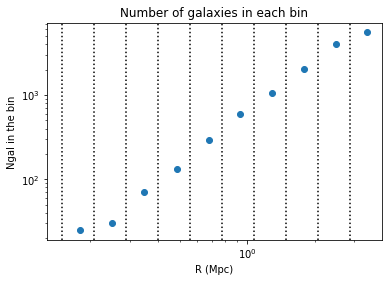

In [20]:
plt.scatter(profile_from_cosmoDC2['radius'], profile_from_cosmoDC2['n_src'], marker='o')
[plt.axvline(x=r, ymin=0, ymax=1e3, color='k', linestyle=':') for r in profile_from_cosmoDC2['radius_min']]
plt.ylabel('Ngal in the bin')
plt.xlabel('R (Mpc)')
plt.xscale('log')
plt.yscale('log')
plt.title('Number of galaxies in each bin')